In [1]:
import numpy as np
import json
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib
from collections import defaultdict
import math
from itertools import combinations

plt.rcParams['figure.figsize'] = [16, 4]
from plot_utils import *

In [2]:
def plot_mouli_te_variation_with_pval(ax,run_list,pval_list,main_enum,plot_item_list,fname_pattern,title,label_prefix=""):
    #Getting the result dict
    result_dict_erm = get_all_result_dict(
                        run_list=run_list,
                        pval_list=pval_list,
                        enum=main_enum,
                        fname_pattern=fname_pattern+"probe_metric_list_erm.json",
    )
    result_dict_cad = get_all_result_dict(
                        run_list=run_list,
                        pval_list=pval_list,
                        enum=main_enum,
                        fname_pattern=fname_pattern+"probe_metric_list_cad.json",
    )
    
    
    #Getting the mouli's tv estimate of the TE
    avg_mouli_tv_pred = get_avg_tv_pred(
            run_list=run_list,
            pval_list=pval_list,
            tv_fname_pattern = fname_pattern+"mouli_pred_tv_data.json"
    )
    
    #Plotting the correlation
    offset_sub=1
    if "nlp_toy3" in fname_pattern:
        offset_sub=0
        correlation_items = ["y-tcausal","y-tconfound","y-tspurious",]
        for corr_item in correlation_items:
            corr_val_mean = np.array([result_dict_erm[pval][corr_item]["mean"] for pval in pval_list])
            corr_val_std = np.array([result_dict_erm[pval][corr_item]["std"] for pval in pval_list])
            ax[0].plot(pval_list,corr_val_mean,ls="-.",marker="o",label=label_prefix+corr_item,alpha=0.7)
            ax[0].fill_between(pval_list,corr_val_mean-corr_val_std,corr_val_mean+corr_val_std,alpha=0.3)
            ax[0].set_xlabel("pval")
            ax[0].set_ylim(0.0,1.0)
            ax[0].set_ylabel("topic correlation")
            ax[0].grid(True)
            ax[0].legend()
            ax[0].set_title(title)
            
    
    #plotting the avg mouli tv
    tv_pval_var_mean = np.array([avg_mouli_tv_pred[pval]["mean"] for pval in pval_list])
    tv_pval_var_std = np.array([avg_mouli_tv_pred[pval]["std"] for pval in pval_list])
    ax[1-offset_sub].plot(pval_list,tv_pval_var_mean,ls="-.",marker="o",alpha=0.7,label=label_prefix)
    ax[1-offset_sub].fill_between(pval_list,tv_pval_var_mean-tv_pval_var_std,tv_pval_var_mean+tv_pval_var_std,alpha=0.3)
    ax[1-offset_sub].set_xlabel("pval")
#     ax[1].set_ylim(0.0,1.0)
    ax[1-offset_sub].set_ylabel("|P(Y|phi(X)) - P(Y|X)|")
    ax[1-offset_sub].grid(True)
    ax[1-offset_sub].set_title(title)
    ax[1-offset_sub].legend()
    
    
    #Plotting the rest the items
    for pidx,plot_item in enumerate(plot_item_list):
        #Plotting the results
        item_yval_erm = np.array([result_dict_erm[pval][plot_item]["mean"] for pval in pval_list])
        yerr_erm = np.array([result_dict_erm[pval][plot_item]["std"] for pval in pval_list])
        #Plotting the item
        ax[pidx+2-offset_sub].plot(pval_list,item_yval_erm,label=label_prefix+"erm",ls="-.",marker="o",alpha=0.7)
        ax[pidx+2-offset_sub].fill_between(pval_list,item_yval_erm-yerr_erm,item_yval_erm+yerr_erm,alpha=0.3)
        
        #Plotting the results
        item_yval_cad = np.array([result_dict_cad[pval][plot_item]["mean"] for pval in pval_list])
        yerr_cad = np.array([result_dict_cad[pval][plot_item]["std"] for pval in pval_list])
        #Plotting the item
        ax[pidx+2-offset_sub].plot(pval_list,item_yval_cad,label=label_prefix+"cad",ls="-.",marker="o",alpha=0.7)
        ax[pidx+2-offset_sub].fill_between(pval_list,item_yval_cad-yerr_cad,item_yval_cad+yerr_cad,alpha=0.3)
        
        
        ax[pidx+2-offset_sub].set_xlabel("pval")
        #ax[pidx+2-offset_sub].set_ylim(-0.3,0.3)
        ax[pidx+2-offset_sub].set_ylabel(plot_item)
        ax[pidx+2-offset_sub].legend()
        ax[pidx+2-offset_sub].grid(True)
        ax[pidx+2-offset_sub].set_title(title)

In [3]:
def plot_mouli_selection_metrics(ax,run_list,topic_list,pval_list,main_enum,mouli_plot_item_list,probe_plot_item_list,inv_fname_pattern,erm_fname_pattern=None):
    avg_mouli_selec_metric_dict = {}
    all_result_dict = {}
    if erm_fname_pattern==None:
        erm_fname_pattern=inv_fname_pattern
    
    #First of all getting the erm (no invariance results)
    avg_mouli_selec_metric_erm = get_avg_tv_pred(run_list= run_list,
                                             pval_list=pval_list,
                                             tv_fname_pattern=erm_fname_pattern+"mouli_erm_data.json",
                                             item_list=mouli_plot_item_list,
    )
    avg_mouli_selec_metric_dict[()] = avg_mouli_selec_metric_erm
    #Loading the result dict for this run
    result_dict_erm = get_all_result_dict(
                        run_list=run_list,
                        pval_list=pval_list,
                        enum=main_enum,
                        fname_pattern=erm_fname_pattern+"probe_metric_list_erm.json",
    )
    all_result_dict[()] = result_dict_erm
#     print(result_dict_erm)
    
    
    #Going over all the topic subset and plotting the metric
    for sidx in range(1,len(topic_list)+1):
        for topic_subset in combinations(topic_list,sidx):
            avg_mouli_selec_metric_dict[sort_topic_tuple(topic_subset)] = get_avg_tv_pred(
                                     run_list= run_list,
                                     pval_list=pval_list,
                                     tv_fname_pattern=inv_fname_pattern+"mouli_({})_data.json".format(",".join(topic_subset)),
                                     item_list=mouli_plot_item_list,
            )
            
            all_result_dict[sort_topic_tuple(topic_subset)]= get_all_result_dict(
                        run_list=run_list,
                        pval_list=pval_list,
                        enum=main_enum,
                        fname_pattern=inv_fname_pattern+"probe_metric_list_({})_cad.json".format(",".join(topic_subset)),
    )
#     print(all_result_dict[()][0.5])
    
    #Merging the dict
    for model in all_result_dict.keys():
        for pval in all_result_dict[model].keys():
            for item in all_result_dict[model][pval].keys():
                avg_mouli_selec_metric_dict[model][pval][item] = all_result_dict[model][pval][item]

    
    #Generating the comnined score for every model
    for model in avg_mouli_selec_metric_dict.keys():
        for pval in pval_list:
            mouli_score = get_model_mouli_score(topic_list,avg_mouli_selec_metric_dict,model,pval)
            avg_mouli_selec_metric_dict[model][pval]["mouli_score"]["mean"]=mouli_score
            avg_mouli_selec_metric_dict[model][pval]["mouli_score"]["std"]=0.0
    
    #Now we will plot one by one for all the plot items for all the invariant models
    for inv_model,avg_mouli_selec_metric in avg_mouli_selec_metric_dict.items():
        for pidx,plot_item in enumerate(mouli_plot_item_list+probe_plot_item_list):
            #Plotting the results
            item_yval = np.array([avg_mouli_selec_metric[pval][plot_item]["mean"] for pval in pval_list])
            yerr = np.array([avg_mouli_selec_metric[pval][plot_item]["std"] for pval in pval_list])
            #Plotting the item
            label = ",".join(inv_model) if len(inv_model)!=0 else "erm"
            ax[pidx].plot(pval_list,item_yval,label=label,ls="-.",marker="o",alpha=0.7)
            ax[pidx].fill_between(pval_list,item_yval-yerr,item_yval+yerr,alpha=0.3)
            
            
            ax[pidx].set_xlabel("pval")
            #ax[pidx+2-offset_sub].set_ylim(-0.3,0.3)
            ax[pidx].set_ylabel(plot_item)
            ax[pidx].legend()
            ax[pidx].grid(True)
            #ax[pidx].set_title(title)
    
    return avg_mouli_selec_metric_dict

# TOY3 dataset

TypeError: get_avg_tv_pred() missing 1 required positional argument: 'item_list'

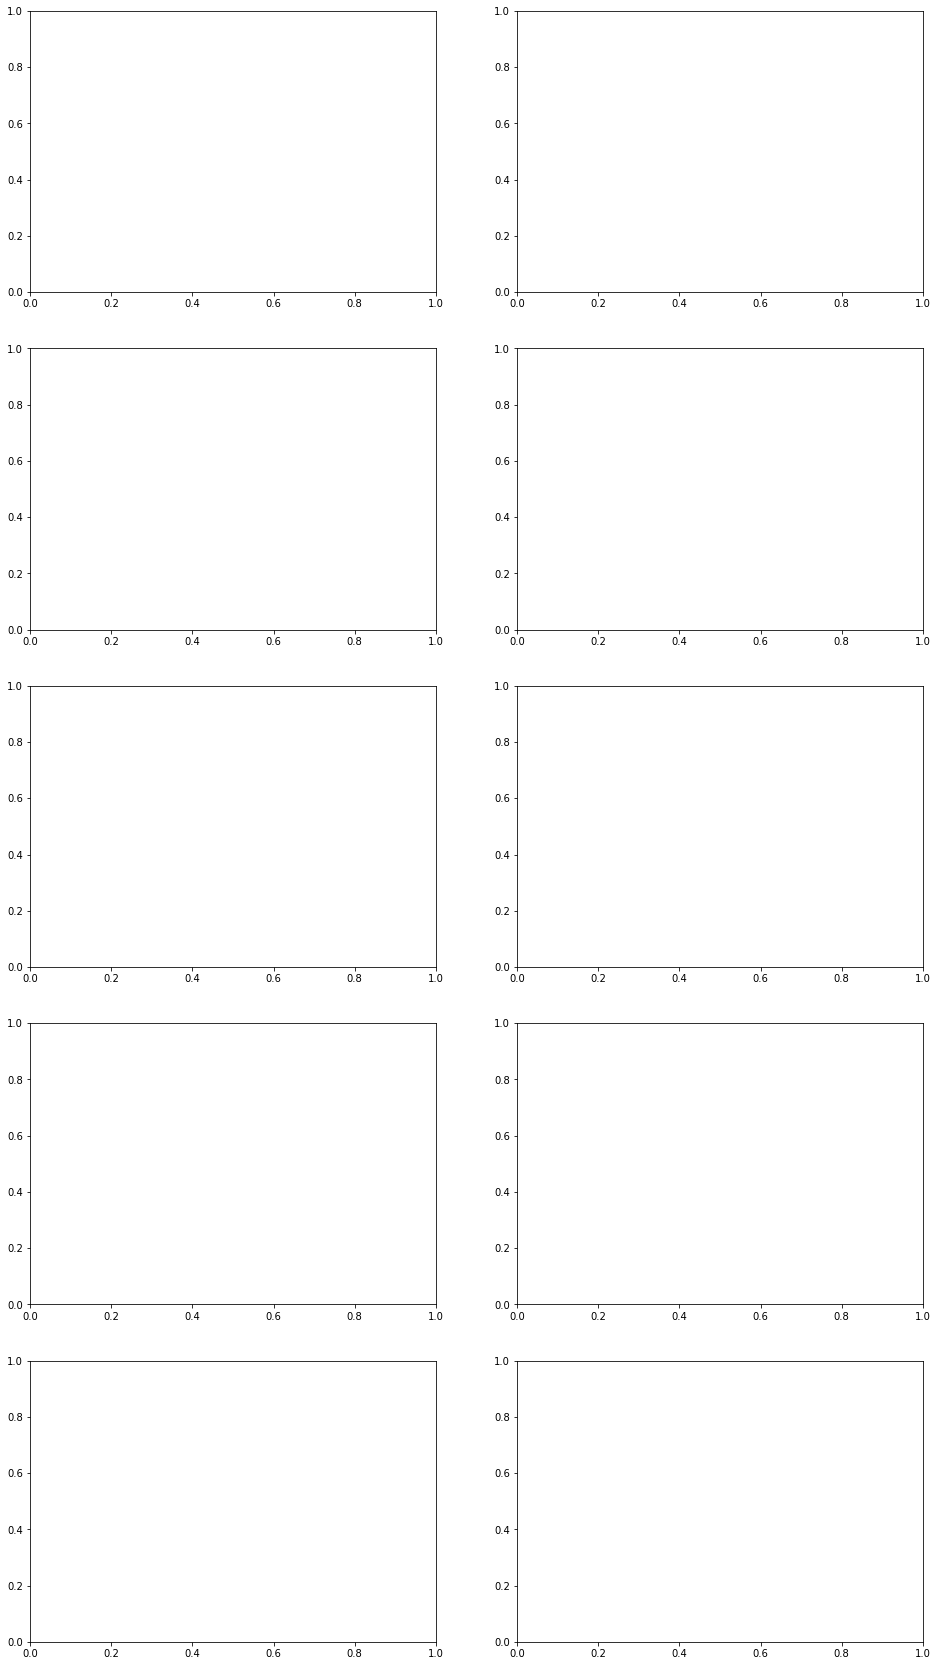

In [40]:
run_list=[0,1,2]
pval_list=[0.5,0.7,0.8,0.9,0.95,0.99]

main_enum=20
topic_name ="spurious"
topic_name_list = ["causal","spurious"]
sample=1000
noise=0.1
mvsel_mode_list=["acc","loss"] #acc,loss
dcf=0.0 #0.0,0.5,1.0


plot_item_list=[
            "acc:main",
            "topic0_smin",
            "topic0_pdelta_all",
]


fname_pattern = "dataset/nlp_toy3/nlp_logs/cad.moulis1toy3.rnum({}).topic({}).sample({}).noise({}).pvaltsp({}).dcf({}).mvsel({})/"


plt.rcParams['figure.figsize'] = [8*2,6*(len(plot_item_list)+2)]
fig,ax = plt.subplots(len(plot_item_list)+2,2)


for topic_name in topic_name_list:
    for midx,mvsel_mode in enumerate(mvsel_mode_list):
        plot_mouli_te_variation_with_pval(ax=ax[:,midx],
                                          run_list=run_list,
                                          pval_list=pval_list,
                                          main_enum=main_enum,
                                          plot_item_list = plot_item_list,
                                          fname_pattern = fname_pattern.format(
                                                                            "{1}",
                                                                            topic_name,
                                                                            sample,
                                                                            noise,
                                                                            "{0}",
                                                                            dcf,
                                                                            mvsel_mode,
                                          ),
                                          title="selection_mode={}".format(mvsel_mode),
                                          label_prefix=topic_name+"_",
        )
plt.show()

## Plotting the metric used for model selection in Mouli

### Invariance using CAD

TypeError: plot_mouli_selection_metrics() got an unexpected keyword argument 'fname_pattern'

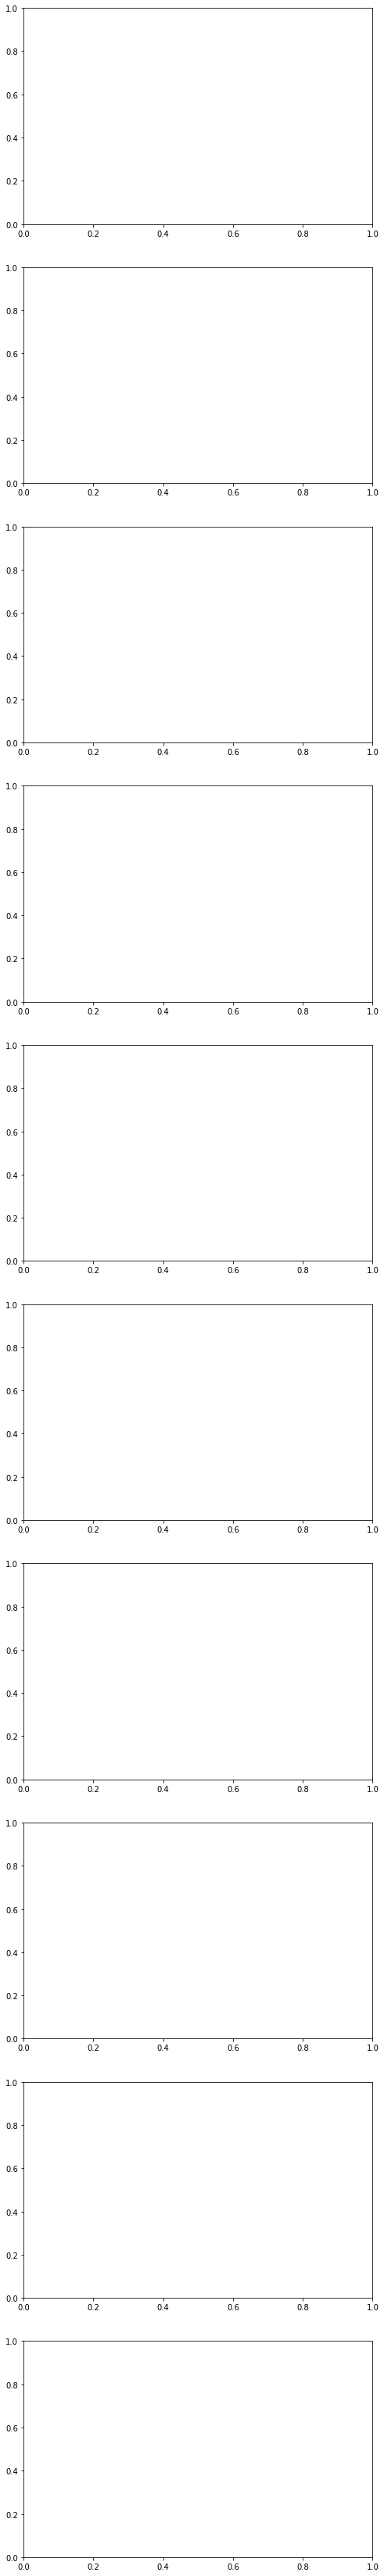

In [15]:
run_list=[0,1,2]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]

main_enum=20
topic_name_list = ["causal","spurious"]
topic_name_in_fname = "all"
sample=1000
noise=0.0
mvsel_mode="loss"
dcf=1.0 #0.0,0.5,1.0


mouli_plot_item_list=[
            "best_train_main_metric",
            "best_train_main_random_metric",
            "mouli_score",
            "best_valid_main_acc",
            "best_valid_main_smin_acc",
            "best_valid_main_pdelta",
]

probe_plot_item_list = [
            "acc:main",
            "topic0_smin",
            "topic0_smaj",
            "topic0_pdelta_all",
]


fname_pattern = "dataset/nlp_toy3/nlp_logs/cad.moulis1toy3.rnum({}).topic({}).sample({}).noise({}).pvaltsp({}).dcf({}).mvsel({})/"


plt.rcParams['figure.figsize'] = [8,6*(len(mouli_plot_item_list+probe_plot_item_list))]
fig,ax = plt.subplots(len(mouli_plot_item_list+probe_plot_item_list),)


avg_mouli_selec_metric_dict=plot_mouli_selection_metrics(ax=ax,
                                     run_list=run_list,
                                     topic_list=topic_name_list,
                                     pval_list=pval_list,
                                     main_enum=main_enum,
                                     mouli_plot_item_list=mouli_plot_item_list,
                                     probe_plot_item_list=probe_plot_item_list,
                                     fname_pattern=fname_pattern.format(
                                                                    "{1}",
                                                                    topic_name_in_fname,
                                                                    sample,
                                                                    noise,
                                                                    "{0}",
                                                                    dcf,
                                                                    mvsel_mode,
                                                  )
)

for pval in pval_list:
    for model in avg_mouli_selec_metric_dict.keys():
        print("model:{}\t\t\t score:{}".format(
                                model,
                                avg_mouli_selec_metric_dict[model][pval]["mouli_score"]["mean"],
        ))
    print("=====================================================================")
    edge_list = ges_minimize(pval,topic_name_list,avg_mouli_selec_metric_dict)
    print("---------------------------------------------------------------------")
    print("pval:",pval)
    print("selected invariance list: ",get_topic_complement(edge_list,topic_name_list))
    print("---------------------------------------------------------------------\n\n\n\n\n\n\n")
plt.show()

### Invariance using te reg

model:()			 score:-40.97337849934894
model:('causal',)			 score:-11.604899088541629
model:('spurious',)			 score:-70.87533569335943
model:('causal', 'spurious')			 score:-28.71824137369788
Initial Edge List:[], initial score:-28.71824137369788
Starting the addition phase
Candidate topic:causal	 score:-70.87533569335943
Candidate topic:spurious	 score:-11.604899088541629

Adding edge: causal
Score after adding edge: -70.87533569335943
Candidate topic:spurious	 score:-40.97337849934894
Starting the removal phase
Candidate topic:causal	 score:-28.71824137369788
Final Invariance List: ('spurious',)
---------------------------------------------------------------------
pval: 0.5
selected invariance list:  ('spurious',)
---------------------------------------------------------------------







model:()			 score:-49.48210652669269
model:('causal',)			 score:-22.721700032552008
model:('spurious',)			 score:-77.01786295572919
model:('causal', 'spurious')			 score:-37.37885538736987
Initial Edg

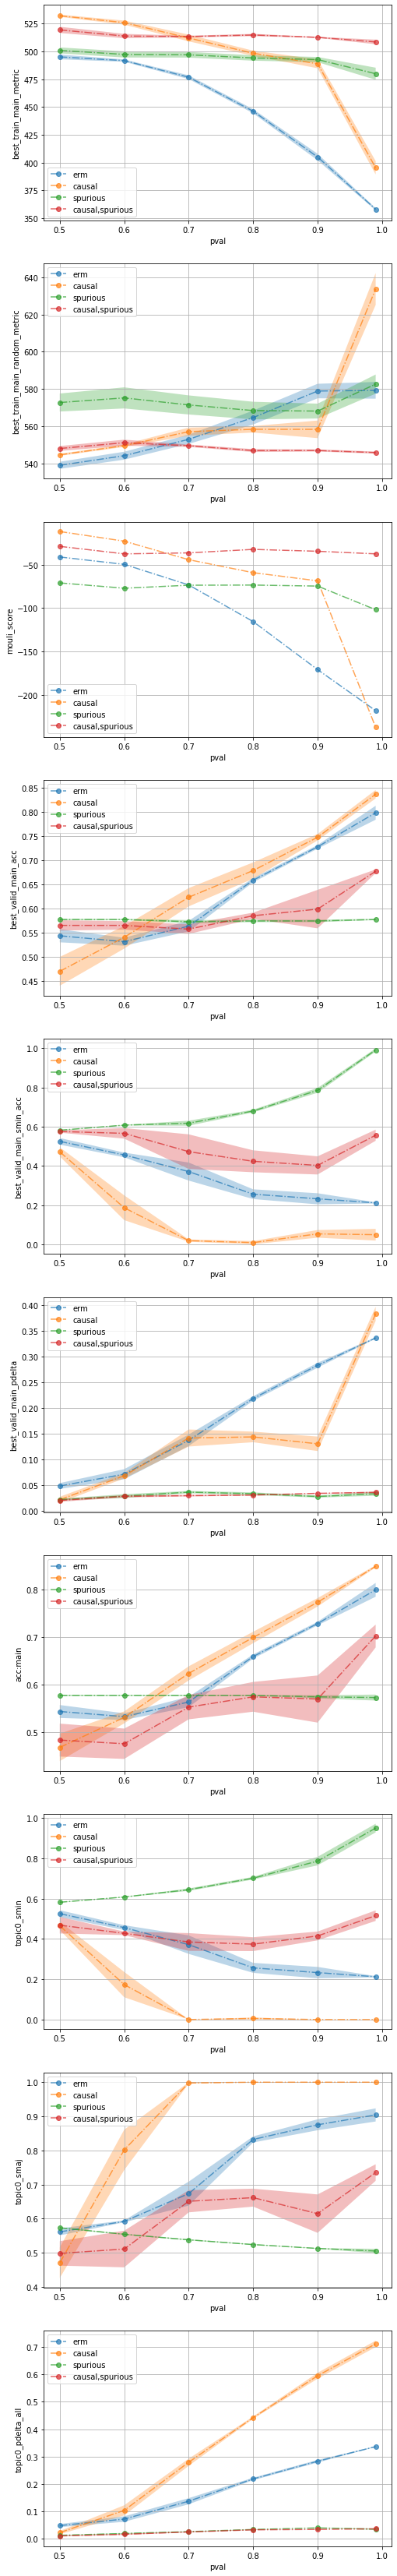

Bad pipe message: %s [b"\xd5r\x93\x9bn6Bs\x7f\xd5\xe8\xcd\x9f`\xf2%\x9dE\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x000\x00.\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06"]
Bad pipe message: %s [b'', b'\x03\x03']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'', b'\x02']
Bad pipe message: %s [b"\xd7\x08'\x1fa\xab\x96\x81\x00"]
Bad pipe message: %s [b'\x05\x02\x06']
B

In [16]:
run_list=[0,1,2]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]

main_enum=20
topic_name_list = ["causal","spurious"]
topic_name_in_fname = "all"
sample=1000
noise=0.0
mvsel_mode="loss"
dcf=1.0 #0.0,0.5,1.0
telambda=10


mouli_plot_item_list=[
            "best_train_main_metric",
            "best_train_main_random_metric",
            "mouli_score",
            "best_valid_main_acc",
            "best_valid_main_smin_acc",
            "best_valid_main_pdelta",
]

probe_plot_item_list = [
            "acc:main",
            "topic0_smin",
            "topic0_smaj",
            "topic0_pdelta_all",
]


inv_fname_pattern = "dataset/nlp_toy3/nlp_logs/cad.moulis1toy3.rnum({}).topic({}).sample({}).noise({}).pvaltsp({}).dcf({}).mvsel({}).telambda({})/"
#We also made erm invariant: so lets use the previously trained erm files (later redo)
erm_fname_pattern = "dataset/nlp_toy3/nlp_logs/cad.moulis1toy3.rnum({}).topic({}).sample({}).noise({}).pvaltsp({}).dcf({}).mvsel({})/"

plt.rcParams['figure.figsize'] = [8,6*(len(mouli_plot_item_list+probe_plot_item_list))]
fig,ax = plt.subplots(len(mouli_plot_item_list+probe_plot_item_list),)


avg_mouli_selec_metric_dict=plot_mouli_selection_metrics(ax=ax,
                                     run_list=run_list,
                                     topic_list=topic_name_list,
                                     pval_list=pval_list,
                                     main_enum=main_enum,
                                     mouli_plot_item_list=mouli_plot_item_list,
                                     probe_plot_item_list=probe_plot_item_list,
                                     inv_fname_pattern=inv_fname_pattern.format(
                                                                    "{1}",
                                                                    topic_name_in_fname,
                                                                    sample,
                                                                    noise,
                                                                    "{0}",
                                                                    dcf,
                                                                    mvsel_mode,
                                                                    telambda,
                                    ),
#                                     erm_fname_pattern=erm_fname_pattern.format(
#                                                                     "{1}",
#                                                                     topic_name_in_fname,
#                                                                     sample,
#                                                                     noise,
#                                                                     "{0}",
#                                                                     dcf,
#                                                                     mvsel_mode,
#                                     ),
                                                
)

for pval in pval_list:
    for model in avg_mouli_selec_metric_dict.keys():
        print("model:{}\t\t\t score:{}".format(
                                model,
                                avg_mouli_selec_metric_dict[model][pval]["mouli_score"]["mean"],
        ))
    print("=====================================================================")
    edge_list = ges_minimize(pval,topic_name_list,avg_mouli_selec_metric_dict)
    print("---------------------------------------------------------------------")
    print("pval:",pval)
    print("selected invariance list: ",get_topic_complement(edge_list,topic_name_list))
    print("---------------------------------------------------------------------\n\n\n\n\n\n\n")
plt.show()

# MNIST34 dataset

### Inv using CAD

TypeError: plot_mouli_selection_metrics() got an unexpected keyword argument 'fname_pattern'

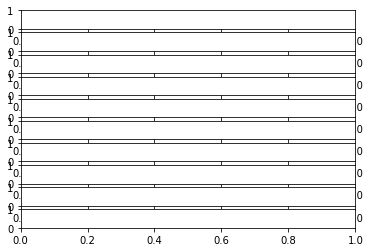

In [7]:
run_list=[0,1,2]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.95,0.99]

main_enum=20
topic_name_list = ["color","rotation"]
topic_name_in_fname = "all"
sample=10000
noise=0.3
mvsel_mode="loss"
dcf=0.0 #0.0,0.5,1.0


mouli_plot_item_list=[
            "best_train_main_metric",
            "best_train_main_random_metric",
            "mouli_score",
            "best_valid_main_acc",
            "best_valid_main_smin_acc",
            "best_valid_main_pdelta",
]


probe_plot_item_list = [
            "acc:main",
            "topic0_smin",
            "topic0_smaj",
            "topic0_pdelta_all",
]


fname_pattern = "dataset/mnist/nlp_logs/cad.moulis1mnist.rnum({}).topic({}).sample({}).noise({}).pvaltsp({}).dcf({}).mvsel({})/"


plt.rcParams['figure.figsize'] = [8,6*(len(mouli_plot_item_list+probe_plot_item_list))]
fig,ax = plt.subplots(len(mouli_plot_item_list+probe_plot_item_list),)


avg_mouli_selec_metric_dict=plot_mouli_selection_metrics(ax=ax,
                                     run_list=run_list,
                                     topic_list=topic_name_list,
                                     pval_list=pval_list,
                                     main_enum=main_enum,
                                     mouli_plot_item_list=mouli_plot_item_list,
                                     probe_plot_item_list=probe_plot_item_list,
                                     fname_pattern=fname_pattern.format(
                                                                    "{1}",
                                                                    topic_name_in_fname,
                                                                    sample,
                                                                    noise,
                                                                    "{0}",
                                                                    dcf,
                                                                    mvsel_mode,
                                                  )
)

for pval in pval_list:
    for model in avg_mouli_selec_metric_dict.keys():
        print("model:{}\t\t\t score:{}".format(
                                model,
                                avg_mouli_selec_metric_dict[model][pval]["mouli_score"]["mean"],
        ))
    print("=====================================================================")
    edge_list = ges_minimize(pval,topic_name_list,avg_mouli_selec_metric_dict)
    print("---------------------------------------------------------------------")
    print("pval:",pval)
    print("selected invariance list: ",get_topic_complement(edge_list,topic_name_list))
    print("---------------------------------------------------------------------\n\n\n\n\n\n\n")
plt.show()

### inv using tereg

model:()			 score:-681.500813802083
model:('color',)			 score:-1.7164713541669698
model:('rotation',)			 score:-416.45784505208303
model:('color', 'rotation')			 score:-54.67822265625
Initial Edge List:[], initial score:-54.67822265625
Starting the addition phase
Candidate topic:color	 score:-416.45784505208303
Candidate topic:rotation	 score:-1.7164713541669698

Adding edge: color
Score after adding edge: -416.45784505208303
Candidate topic:rotation	 score:-681.500813802083

Adding edge: rotation
Score after adding edge: -681.500813802083
Starting the removal phase
Candidate topic:color	 score:-1.7164713541669698
Candidate topic:rotation	 score:-416.45784505208303
Final Invariance List: ()
---------------------------------------------------------------------
pval: 0.5
selected invariance list:  ()
---------------------------------------------------------------------







model:()			 score:-414.79638671875
model:('color',)			 score:-32.56022135416606
model:('rotation',)			 score:-778

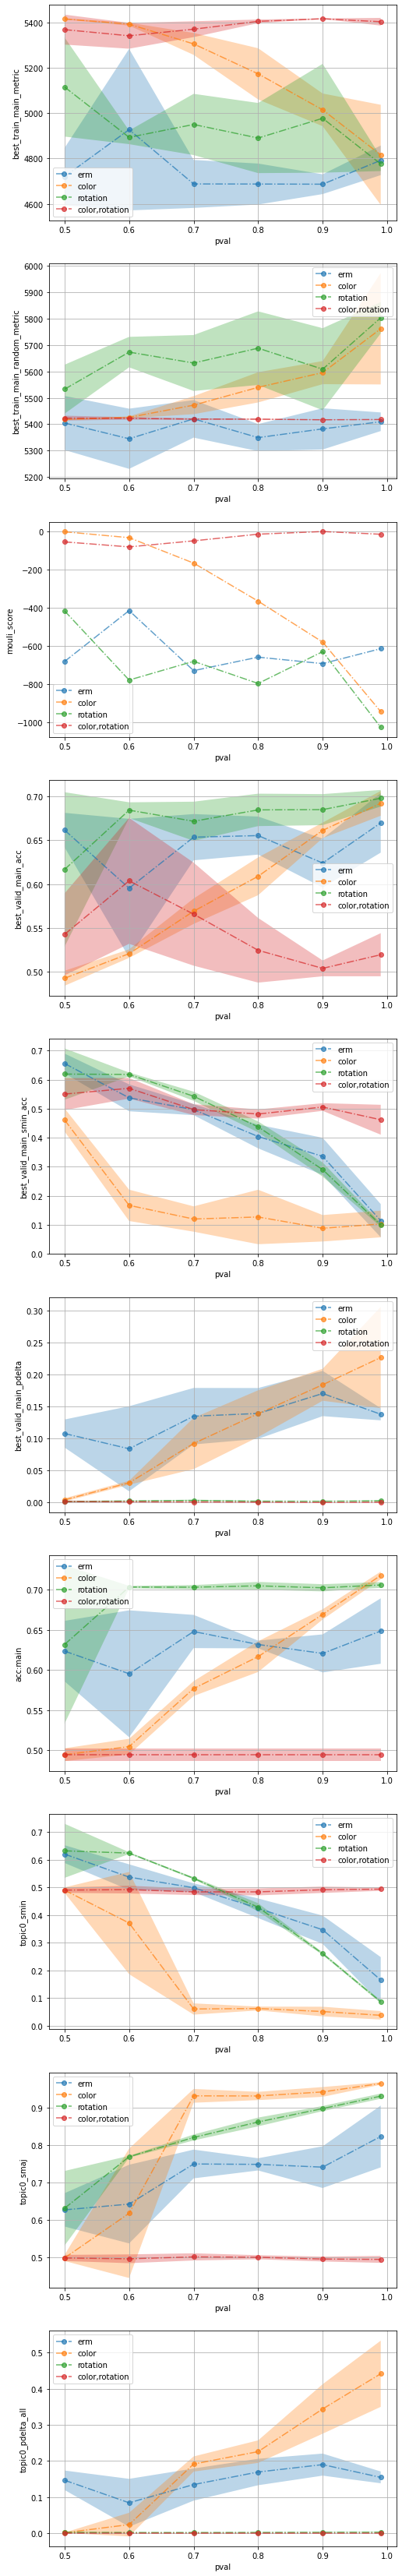

In [19]:
run_list=[0,1,2]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]

main_enum=20
topic_name_list = ["color","rotation"]
topic_name_in_fname = "all"
sample=10000
noise=0.3
mvsel_mode="loss"
dcf=0.0 #0.0,0.5,1.0
telambda=1000 #1 10 100 1000


mouli_plot_item_list=[
            "best_train_main_metric",
            "best_train_main_random_metric",
            "mouli_score",
            "best_valid_main_acc",
            "best_valid_main_smin_acc",
            "best_valid_main_pdelta",
]


probe_plot_item_list = [
            "acc:main",
            "topic0_smin",
            "topic0_smaj",
            "topic0_pdelta_all",
]


inv_fname_pattern = "dataset/mnist/nlp_logs/cad.moulis1mnist.rnum({}).topic({}).sample({}).noise({}).pvaltsp({}).dcf({}).mvsel({}).telambda({})/"
erm_fname_pattern = "dataset/mnist/nlp_logs/cad.moulis1mnist.rnum({}).topic({}).sample({}).noise({}).pvaltsp({}).dcf({}).mvsel({})/"

plt.rcParams['figure.figsize'] = [8,6*(len(mouli_plot_item_list+probe_plot_item_list))]
fig,ax = plt.subplots(len(mouli_plot_item_list+probe_plot_item_list),)


avg_mouli_selec_metric_dict=plot_mouli_selection_metrics(ax=ax,
                                     run_list=run_list,
                                     topic_list=topic_name_list,
                                     pval_list=pval_list,
                                     main_enum=main_enum,
                                     mouli_plot_item_list=mouli_plot_item_list,
                                     probe_plot_item_list=probe_plot_item_list,
                                     inv_fname_pattern=inv_fname_pattern.format(
                                                                    "{1}",
                                                                    topic_name_in_fname,
                                                                    sample,
                                                                    noise,
                                                                    "{0}",
                                                                    dcf,
                                                                    mvsel_mode,
                                                                    telambda,
                                     ),
#                                      erm_fname_pattern=erm_fname_pattern.format(
#                                                                     "{1}",
#                                                                     topic_name_in_fname,
#                                                                     sample,
#                                                                     noise,
#                                                                     "{0}",
#                                                                     dcf,
#                                                                     mvsel_mode,
#                                      ),
)

for pval in pval_list:
    for model in avg_mouli_selec_metric_dict.keys():
        print("model:{}\t\t\t score:{}".format(
                                model,
                                avg_mouli_selec_metric_dict[model][pval]["mouli_score"]["mean"],
        ))
    print("=====================================================================")
    edge_list = ges_minimize(pval,topic_name_list,avg_mouli_selec_metric_dict)
    print("---------------------------------------------------------------------")
    print("pval:",pval)
    print("selected invariance list: ",get_topic_complement(edge_list,topic_name_list))
    print("---------------------------------------------------------------------\n\n\n\n\n\n\n")
plt.show()

# CivilComments dataset

model:()			 score:-1.1914876302082575
model:('gender',)			 score:-1253.0181884765627
Initial Edge List:[], initial score:-1253.0181884765627
Starting the addition phase
Candidate topic:gender	 score:-1.1914876302082575
Starting the removal phase
Final Invariance List: ('gender',)
---------------------------------------------------------------------
pval: 0.5
selected invariance list:  ('gender',)
---------------------------------------------------------------------







model:()			 score:0.21663411458325754
model:('gender',)			 score:-1043.700480143229
Initial Edge List:[], initial score:-1043.700480143229
Starting the addition phase
Candidate topic:gender	 score:0.21663411458325754
Starting the removal phase
Final Invariance List: ('gender',)
---------------------------------------------------------------------
pval: 0.6
selected invariance list:  ('gender',)
---------------------------------------------------------------------







model:()			 score:1.7814127604166288
model:('gen

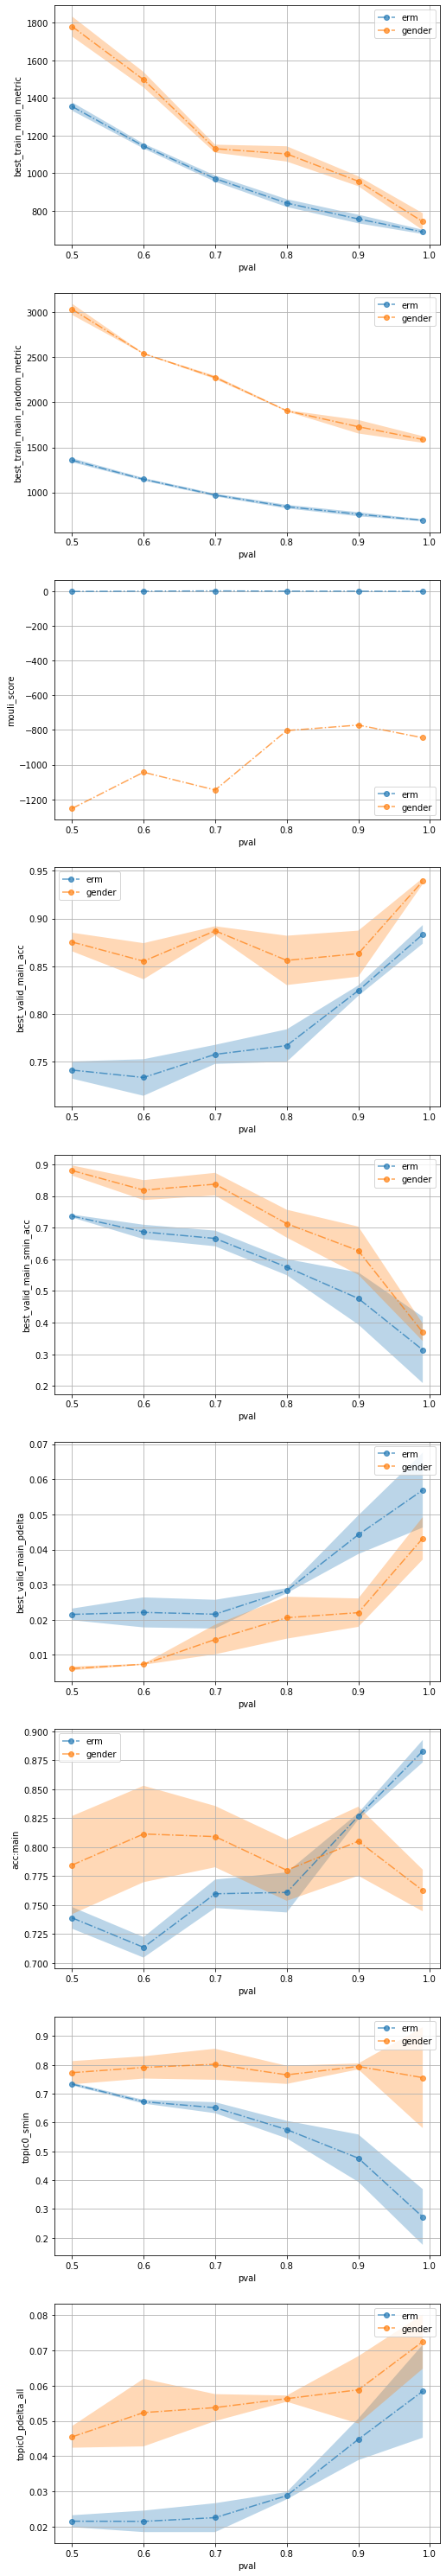

In [60]:
run_list=[0,1,2]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]

main_enum=20
# topic_name_list = ["race",]
topic_name_list = ["gender",]
sample=5000

# topic_name_list = ["religion",]
# sample=4000

topic_name_in_fname = topic_name_list[0]
noise=0.0
mvsel_mode="loss"



mouli_plot_item_list=[
            "best_train_main_metric",
            "best_train_main_random_metric",
            "mouli_score",
            "best_valid_main_acc",
            "best_valid_main_smin_acc",
            "best_valid_main_pdelta",
]


probe_plot_item_list = [
            "acc:main",
            "topic0_smin",
            "topic0_pdelta_all",
]


fname_pattern = "dataset/civilcomments/nlp_logs/cad.moulis1civil.rnum({}).topic({}).sample({}).noise({}).pval({}).mvsel({})/"


plt.rcParams['figure.figsize'] = [8,6*(len(mouli_plot_item_list+probe_plot_item_list))]
fig,ax = plt.subplots(len(mouli_plot_item_list+probe_plot_item_list),)


avg_mouli_selec_metric_dict=plot_mouli_selection_metrics(ax=ax,
                                     run_list=run_list,
                                     topic_list=topic_name_list,
                                     pval_list=pval_list,
                                     main_enum=main_enum,
                                     mouli_plot_item_list=mouli_plot_item_list,
                                     probe_plot_item_list=probe_plot_item_list,
                                     inv_fname_pattern=fname_pattern.format(
                                                                    "{1}",
                                                                    topic_name_in_fname,
                                                                    sample,
                                                                    noise,
                                                                    "{0}",
                                                                    mvsel_mode,
                                                  )
)

for pval in pval_list:
    for model in avg_mouli_selec_metric_dict.keys():
        print("model:{}\t\t\t score:{}".format(
                                model,
                                avg_mouli_selec_metric_dict[model][pval]["mouli_score"]["mean"],
        ))
    print("=====================================================================")
    edge_list = ges_minimize(pval,topic_name_list,avg_mouli_selec_metric_dict)
    print("---------------------------------------------------------------------")
    print("pval:",pval)
    print("selected invariance list: ",get_topic_complement(edge_list,topic_name_list))
    print("---------------------------------------------------------------------\n\n\n\n\n\n\n")
plt.show()

### using te_reg for inv

model:()			 score:2.389933268229015
model:('religion',)			 score:-2625.1119384765625
Initial Edge List:[], initial score:-2625.1119384765625
Starting the addition phase
Candidate topic:religion	 score:2.389933268229015
Starting the removal phase
Final Invariance List: ('religion',)
---------------------------------------------------------------------
pval: 0.5
selected invariance list:  ('religion',)
---------------------------------------------------------------------







model:()			 score:1.8908487955728788
model:('religion',)			 score:-2631.270670572917
Initial Edge List:[], initial score:-2631.270670572917
Starting the addition phase
Candidate topic:religion	 score:1.8908487955728788
Starting the removal phase
Final Invariance List: ('religion',)
---------------------------------------------------------------------
pval: 0.6
selected invariance list:  ('religion',)
---------------------------------------------------------------------







model:()			 score:0.9108072916667425
m

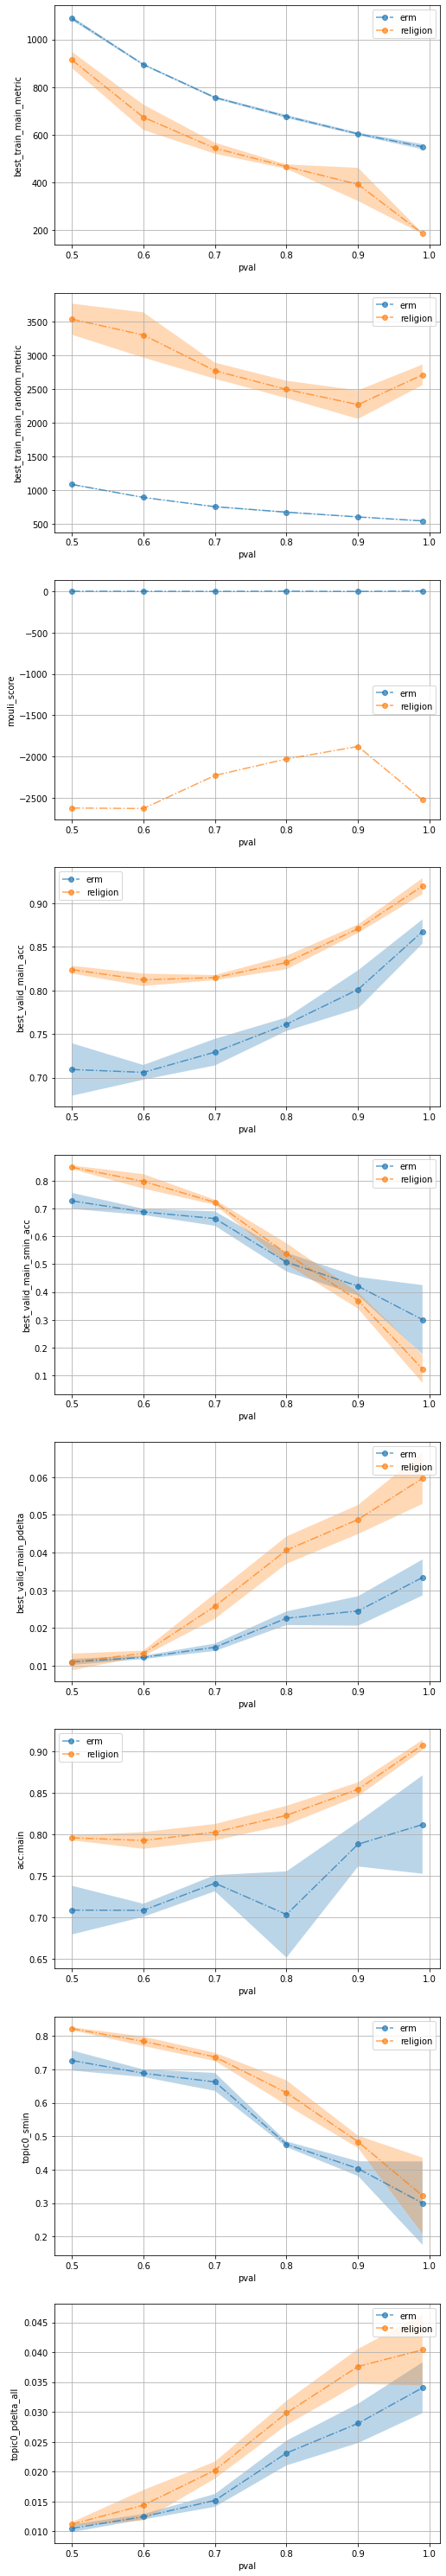

In [12]:
run_list=[0,1,2]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]

main_enum=20
# topic_name_list = ["race",]
# topic_name_list = ["gender",]
# sample=5000

topic_name_list = ["religion",]
sample=4000

topic_name_in_fname = topic_name_list[0]
noise=0.0
mvsel_mode="loss"
telambda=1   #1,10,100,1000



mouli_plot_item_list=[
            "best_train_main_metric",
            "best_train_main_random_metric",
            "mouli_score",
            "best_valid_main_acc",
            "best_valid_main_smin_acc",
            "best_valid_main_pdelta",
]


probe_plot_item_list = [
            "acc:main",
            "topic0_smin",
            "topic0_pdelta_all",
]


inv_fname_pattern = "dataset/civilcomments/nlp_logs/cad.moulis1civil.rnum({}).topic({}).sample({}).noise({}).pval({}).mvsel({}).telambda({})/"
# erm_fname_pattern = "dataset/civilcomments/nlp_logs/cad.moulis1civil.rnum({}).topic({}).sample({}).noise({}).pval({}).mvsel({})/"

plt.rcParams['figure.figsize'] = [8,6*(len(mouli_plot_item_list+probe_plot_item_list))]
fig,ax = plt.subplots(len(mouli_plot_item_list+probe_plot_item_list),)


avg_mouli_selec_metric_dict=plot_mouli_selection_metrics(ax=ax,
                                     run_list=run_list,
                                     topic_list=topic_name_list,
                                     pval_list=pval_list,
                                     main_enum=main_enum,
                                     mouli_plot_item_list=mouli_plot_item_list,
                                     probe_plot_item_list=probe_plot_item_list,
                                     inv_fname_pattern=inv_fname_pattern.format(
                                                                    "{1}",
                                                                    topic_name_in_fname,
                                                                    sample,
                                                                    noise,
                                                                    "{0}",
                                                                    mvsel_mode,
                                                                    telambda,
                                     ),
)

for pval in pval_list:
    for model in avg_mouli_selec_metric_dict.keys():
        print("model:{}\t\t\t score:{}".format(
                                model,
                                avg_mouli_selec_metric_dict[model][pval]["mouli_score"]["mean"],
        ))
    print("=====================================================================")
    edge_list = ges_minimize(pval,topic_name_list,avg_mouli_selec_metric_dict)
    print("---------------------------------------------------------------------")
    print("pval:",pval)
    print("selected invariance list: ",get_topic_complement(edge_list,topic_name_list))
    print("---------------------------------------------------------------------\n\n\n\n\n\n\n")
plt.show()

# AAE dataset

model:()			 score:-19.485921223958485
model:('race',)			 score:-129.79833984375
Initial Edge List:[], initial score:-129.79833984375
Starting the addition phase
Candidate topic:race	 score:-19.485921223958485
Starting the removal phase
Final Invariance List: ('race',)
---------------------------------------------------------------------
pval: 0.5
selected invariance list:  ('race',)
---------------------------------------------------------------------







model:()			 score:-15.31689453125
model:('race',)			 score:-75.3994140625
Initial Edge List:[], initial score:-75.3994140625
Starting the addition phase
Candidate topic:race	 score:-15.31689453125
Starting the removal phase
Final Invariance List: ('race',)
---------------------------------------------------------------------
pval: 0.6
selected invariance list:  ('race',)
---------------------------------------------------------------------







model:()			 score:-2.089599609375
model:('race',)			 score:-48.764811197916515
Initial

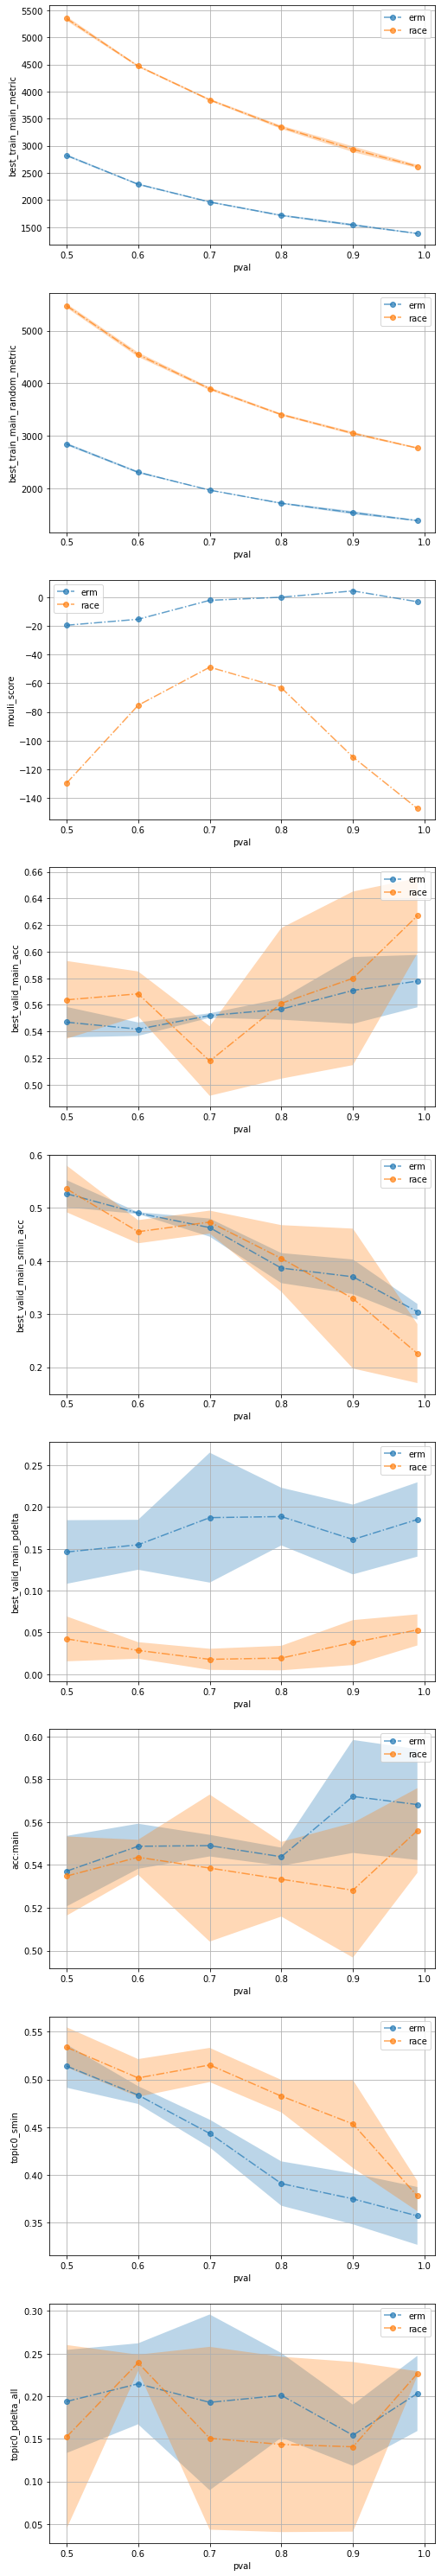

In [48]:
run_list=[0,1,2]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]

main_enum=20
topic_name_list = ["race",]
# topic_name_list = ["gender",]
sample=10000

# topic_name_list = ["religion",]
# sample=4000

topic_name_in_fname = topic_name_list[0]
noise=0.3
mvsel_mode="loss"



mouli_plot_item_list=[
            "best_train_main_metric",
            "best_train_main_random_metric",
            "mouli_score",
            "best_valid_main_acc",
            "best_valid_main_smin_acc",
            "best_valid_main_pdelta",
]


probe_plot_item_list = [
            "acc:main",
            "topic0_smin",
            "topic0_pdelta_all",
]


fname_pattern = "dataset/twitter_aae_sentiment_race/nlp_logs/cad.moulis1aae.rnum({}).topic({}).sample({}).noise({}).pval({}).mvsel({})/"


plt.rcParams['figure.figsize'] = [8,6*(len(mouli_plot_item_list+probe_plot_item_list))]
fig,ax = plt.subplots(len(mouli_plot_item_list+probe_plot_item_list),)


avg_mouli_selec_metric_dict=plot_mouli_selection_metrics(ax=ax,
                                     run_list=run_list,
                                     topic_list=topic_name_list,
                                     pval_list=pval_list,
                                     main_enum=main_enum,
                                     mouli_plot_item_list=mouli_plot_item_list,
                                     probe_plot_item_list=probe_plot_item_list,
                                     inv_fname_pattern=fname_pattern.format(
                                                                    "{1}",
                                                                    topic_name_in_fname,
                                                                    sample,
                                                                    noise,
                                                                    "{0}",
                                                                    mvsel_mode,
                                                  )
)

for pval in pval_list:
    for model in avg_mouli_selec_metric_dict.keys():
        print("model:{}\t\t\t score:{}".format(
                                model,
                                avg_mouli_selec_metric_dict[model][pval]["mouli_score"]["mean"],
        ))
    print("=====================================================================")
    edge_list = ges_minimize(pval,topic_name_list,avg_mouli_selec_metric_dict)
    print("---------------------------------------------------------------------")
    print("pval:",pval)
    print("selected invariance list: ",get_topic_complement(edge_list,topic_name_list))
    print("---------------------------------------------------------------------\n\n\n\n\n\n\n")
plt.show()

### Inv using te reg

model:()			 score:-57.44775390625
model:('race',)			 score:-2058.123942057292
Initial Edge List:[], initial score:-2058.123942057292
Starting the addition phase
Candidate topic:race	 score:-57.44775390625
Starting the removal phase
Final Invariance List: ('race',)
---------------------------------------------------------------------
pval: 0.5
selected invariance list:  ('race',)
---------------------------------------------------------------------







model:()			 score:-39.0048828125
model:('race',)			 score:-1674.0190429687505
Initial Edge List:[], initial score:-1674.0190429687505
Starting the addition phase
Candidate topic:race	 score:-39.0048828125
Starting the removal phase
Final Invariance List: ('race',)
---------------------------------------------------------------------
pval: 0.6
selected invariance list:  ('race',)
---------------------------------------------------------------------







model:()			 score:-31.512369791666742
model:('race',)			 score:-1547.1184082031255

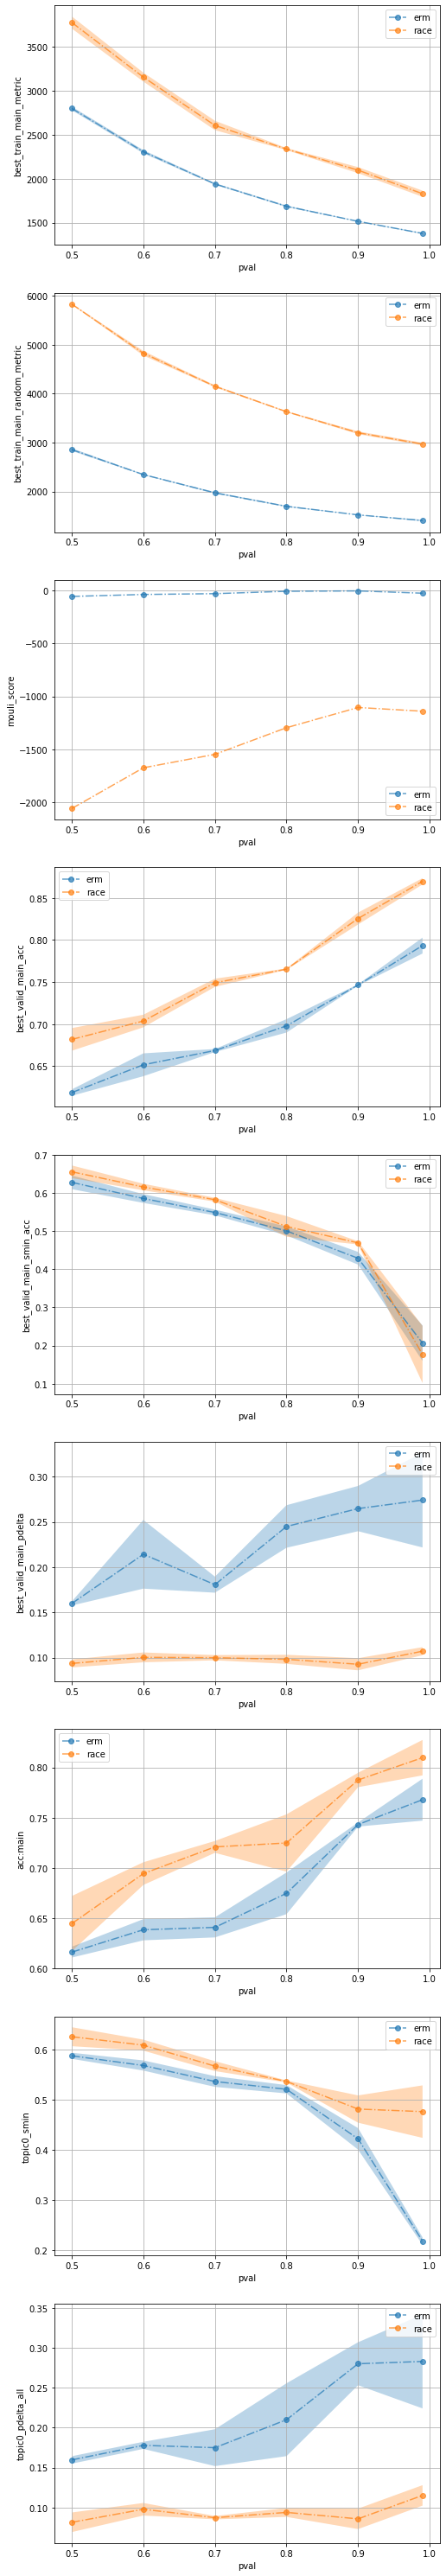

In [14]:
run_list=[0,1,2]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]

main_enum=20
topic_name_list = ["race",]
# topic_name_list = ["gender",]
sample=10000

# topic_name_list = ["religion",]
# sample=4000

topic_name_in_fname = topic_name_list[0]
noise=0.0
mvsel_mode="loss"
telambda=10   #1,10,100,1000



mouli_plot_item_list=[
            "best_train_main_metric",
            "best_train_main_random_metric",
            "mouli_score",
            "best_valid_main_acc",
            "best_valid_main_smin_acc",
            "best_valid_main_pdelta",
]


probe_plot_item_list = [
            "acc:main",
            "topic0_smin",
            "topic0_pdelta_all",
]


inv_fname_pattern = "dataset/twitter_aae_sentiment_race/nlp_logs/cad.moulis1aae.rnum({}).topic({}).sample({}).noise({}).pval({}).mvsel({}).telambda({})/"
erm_fname_pattern = "dataset/twitter_aae_sentiment_race/nlp_logs/cad.moulis1aae.rnum({}).topic({}).sample({}).noise({}).pval({}).mvsel({})/"

plt.rcParams['figure.figsize'] = [8,6*(len(mouli_plot_item_list+probe_plot_item_list))]
fig,ax = plt.subplots(len(mouli_plot_item_list+probe_plot_item_list),)


avg_mouli_selec_metric_dict=plot_mouli_selection_metrics(ax=ax,
                                     run_list=run_list,
                                     topic_list=topic_name_list,
                                     pval_list=pval_list,
                                     main_enum=main_enum,
                                     mouli_plot_item_list=mouli_plot_item_list,
                                     probe_plot_item_list=probe_plot_item_list,
                                     inv_fname_pattern=inv_fname_pattern.format(
                                                                    "{1}",
                                                                    topic_name_in_fname,
                                                                    sample,
                                                                    noise,
                                                                    "{0}",
                                                                    mvsel_mode,
                                                                    telambda,
                                     ),
                                     erm_fname_pattern=erm_fname_pattern.format(
                                                                    "{1}",
                                                                    topic_name_in_fname,
                                                                    sample,
                                                                    noise,
                                                                    "{0}",
                                                                    mvsel_mode,
                                                                    telambda,
                                     ),
)

for pval in pval_list:
    for model in avg_mouli_selec_metric_dict.keys():
        print("model:{}\t\t\t score:{}".format(
                                model,
                                avg_mouli_selec_metric_dict[model][pval]["mouli_score"]["mean"],
        ))
    print("=====================================================================")
    edge_list = ges_minimize(pval,topic_name_list,avg_mouli_selec_metric_dict)
    print("---------------------------------------------------------------------")
    print("pval:",pval)
    print("selected invariance list: ",get_topic_complement(edge_list,topic_name_list))
    print("---------------------------------------------------------------------\n\n\n\n\n\n\n")
plt.show()